# ML - Problem Set 1: Predicting Income

In [ ]:
# ----------------------------------------------------------------------
# Instala librerias
# ----------------------------------------------------------------------

In [ ]:
# ----------------------------------------------------------------------
# Importar librerias
# ----------------------------------------------------------------------
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import re

## 2. Data

In [ ]:
# ----------------------------------------------------------------------
# Adquisición de datos
# ----------------------------------------------------------------------
base_url = "https://ignaciomsarmiento.github.io/GEIH2018_sample/pages/geih_page_{}.html"
all_data = []

for i in range(1, 11):  # Iterar sobre las 10 páginas
    url = base_url.format(i)
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extraer la tabla de la página
    table = soup.find('table')
    if table:
        # Encabezados de la tabla
        headers = [th.text.strip() for th in table.find_all('th')]

        # Filas de la tabla
        rows = [
            [cell.text.strip() for cell in row.find_all('td')]
            for row in table.find_all('tr')[1:]  # Excluir encabezado
        ]

        # Crear un DataFrame para la página actual
        df = pd.DataFrame(rows, columns=headers)
        all_data.append(df)

# Concatenar todos los DataFrames en uno solo
final_data = pd.concat(all_data, ignore_index=True)

# Guardar en un archivo CSV
final_data.to_csv("geih_2018_bogota.csv", index=False)

In [ ]:
# ----------------------------------------------------------------------
# Cargar y filtrar datos
# ----------------------------------------------------------------------

final_data = pd.read_csv("geih_2018_bogota.csv")  # Tomar del csv directamente para no repetir extraccion

filtered_data = final_data[
    (final_data['age'].astype(float) > 18) &  # Mayores de 18 años
    (final_data['ocu'].astype(float) == 1)   # Personas ocupadas
].copy()

filtered_data

<ipython-input-52-dc1f0a26ed91>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['hourly_wage'] = filtered['y_salary_m'].astype(float) / filtered['hoursWorkUsual'].astype(float)


In [ ]:
# ----------------------------------------------------------------------
# Manejar datos faltantes y con salario cero sin eliminar datos
# ----------------------------------------------------------------------

# Convertir 'y_salary_m' (salario mensual) a numérico
filtered_data['y_salary_m'] = pd.to_numeric(filtered_data['y_salary_m'], errors='coerce')

# Imputar salario nulo o cero con la mediana
imputer = SimpleImputer(strategy='median')
filtered_data['y_salary_m'] = imputer.fit_transform(filtered_data[['y_salary_m']])

# Identificar columnas numéricas y categóricas
numeric_columns = filtered_data.select_dtypes(include=['number']).columns
categorical_columns = filtered_data.select_dtypes(exclude=['number']).columns

# Eliminar columnas numéricas completamente nulas antes de imputar
numeric_data = filtered_data[numeric_columns]
numeric_data = numeric_data.dropna(axis=1, how='all')  # Eliminar columnas completamente vacías

# Imputación de valores faltantes en columnas numéricas (mediana)
imputer_numeric = SimpleImputer(strategy='median')
numeric_data_imputed = pd.DataFrame(imputer_numeric.fit_transform(numeric_data), columns=numeric_data.columns)

# Imputar valores faltantes en columnas categóricas (moda)
imputer_categorical = SimpleImputer(strategy='most_frequent')
categorical_data_imputed = pd.DataFrame(
    imputer_categorical.fit_transform(filtered_data[categorical_columns]),
    columns=categorical_columns
)

# Reunir datos numéricos y categóricos imputados
filtered_data_cleaned = pd.concat([numeric_data_imputed, categorical_data_imputed], axis=1)

filtered_data_cleaned

,Unnamed: 0,directorio,secuencia_p,orden,clase,mes,estrato1,sex,age,p6050,...,y_accidentes_m,y_salarySec_m,y_ingLab_m_ha,y_gananciaNeta_m,y_gananciaNetaAgro_m,y_gananciaIndep_m,y_gananciaIndep_m_hu,y_total_m,y_total_m_ha,hourly_wage
4022,806,4545900,1,1,1,2,1,0,51,1,...,NaN,NaN,3402.777832,NaN,NaN,NaN,NaN,7.000000e+05,3402.777832,14583.333333
20318,1012,4692470,1,2,1,8,1,0,26,2,...,NaN,NaN,6513.293945,NaN,NaN,NaN,NaN,1.339878e+06,6513.293945,22916.666667
4289,1073,4551458,1,3,1,2,2,1,22,3,...,NaN,NaN,7056.118652,NaN,NaN,NaN,NaN,1.451544e+06,7056.118652,25000.000000
1586,1587,4526837,1,1,1,1,3,1,50,1,...,NaN,NaN,9727.083008,NaN,NaN,NaN,NaN,2.001000e+06,9727.083008,37500.000000
7125,691,4577383,1,2,1,3,2,0,22,2,...,NaN,NaN,4286.664062,NaN,NaN,NaN,NaN,8.818280e+05,4286.664062,16275.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19083,2995,4680397,1,3,1,7,2,0,19,3,...,NaN,NaN,4226.507812,NaN,NaN,NaN,NaN,8.694530e+05,4226.507812,16275.875000
4367,1151,4551482,1,5,1,2,3,1,32,9,...,NaN,NaN,6494.444336,NaN,NaN,NaN,NaN,2.004000e+06,6494.444336,25000.000000
20916,1610,4699051,1,1,1,8,6,0,50,1,...,NaN,NaN,182291.671875,NaN,NaN,NaN,NaN,3.125000e+07,182291.671875,750000.000000
28017,2275,4760968,1,1,1,11,2,0,55,1,...,NaN,NaN,5512.945801,NaN,NaN,NaN,NaN,1.063211e+06,5512.945801,20000.000000


## Predicting wages


Resultados de RMSE para cada modelo:
Linear Regression: RMSE = 0.01
Polynomial Regression (degree=2): RMSE = 65550.05
Decision Tree (max_depth=5): RMSE = 20824.10
Random Forest (n_estimators=50): RMSE = 6894.06
Gradient Boosting: RMSE = 3664.13

Mejor modelo: Linear Regression


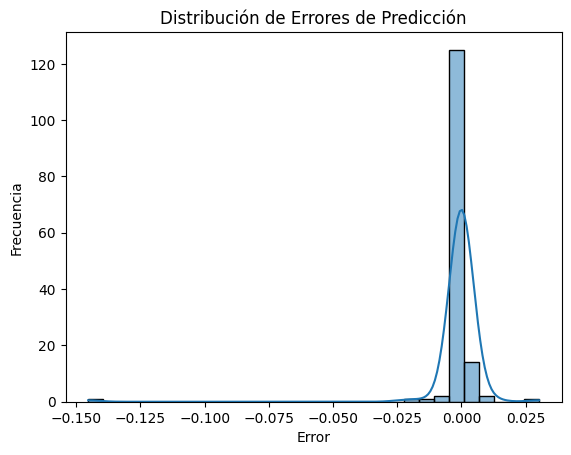

In [ ]:
# ----------------------------------------------------------------------
# Modelado y evaluación
# ----------------------------------------------------------------------

# Convertir las variables categóricas en variables dummy (one-hot encoding)
X = filtered_data_cleaned.drop(columns=['y_salary_m'])  # 'y_salary_m' es el objetivo
y = filtered_data_cleaned['y_salary_m']

# Filtrar la muestra para que el procesamiento sea más rápido
X = X.sample(frac=0.01, random_state=123)  # Selecciona una muestra del 1%
y = y.loc[X.index]  # Asegurarse de que 'y' tiene las mismas filas que 'X'

# Aplicar One-Hot Encoding a las variables categóricas
X = pd.get_dummies(X, drop_first=True)  # drop_first=True para evitar la multicolinealidad

# Dividir los datos en un conjunto de entrenamiento (70%) y un conjunto de prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Especificaciones de los modelos a evaluar
models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression (degree=2)": PolynomialFeatures(degree=2),
    "Polynomial Regression (degree=3)": PolynomialFeatures(degree=3),
    "Decision Tree (max_depth=5)": DecisionTreeRegressor(max_depth=5),
    "Decision Tree (max_depth=10)": DecisionTreeRegressor(max_depth=10),
    "Random Forest (n_estimators=50)": RandomForestRegressor(n_estimators=50, random_state=123),
    "Random Forest (n_estimators=100)": RandomForestRegressor(n_estimators=100, random_state=123),
    "Gradient Boosting": GradientBoostingRegressor(random_state=123),
    "Support Vector Machine (RBF)": SVR(kernel='rbf'),
    "K-Nearest Neighbors (n_neighbors=5)": KNeighborsRegressor(n_neighbors=5)
}

In [ ]:
# ----------------------------------------------------------------------
# Evaluación del desempeño predictivo de los modelos
# ----------------------------------------------------------------------

# Diccionario para almacenar los resultados de RMSE
results = {}

# Evaluar cada modelo
for name, model in models.items():
    if "Polynomial" in name:
        # Extraer el grado del polinomio de la cadena de nombre del modelo usando expresión regular
        degree = int(re.search(r'\d+', name.split('=')[-1]).group())  # Extrae el número
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)

        # Ajustar el modelo de regresión lineal con las características polinómicas
        linear_poly = LinearRegression()
        linear_poly.fit(X_train_poly, y_train)
        y_pred = linear_poly.predict(X_test_poly)

        # Calcular RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results[name] = rmse
    else:
        # Para otros modelos
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calcular RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results[name] = rmse

# Mostrar los resultados de RMSE para cada modelo
print("\nResultados de RMSE para cada modelo:")
for model, error in results.items():
    print(f"{model}: RMSE = {error:.2f}")

# Mejor modelo y errores
best_model_name = min(results, key=results.get)
print(f"\nMejor modelo: {best_model_name}")

# Calcular errores de predicción para el mejor modelo
if "Polynomial" in best_model_name:
    degree = int(re.search(r'\d+', best_model_name.split('=')[-1]).group())  # Extraer grado
    poly = PolynomialFeatures(degree=degree)
    X_test_poly = poly.transform(X_test)
    errors = y_test - linear_poly.predict(X_test_poly)
else:
    errors = y_test - models[best_model_name].predict(X_test)

# Visualización de errores
sns.histplot(errors, kde=True, bins=30)
plt.title('Distribución de Errores de Predicción')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
# ----------------------------------------------------------------------
# Validación Cruzada K-Fold
# ----------------------------------------------------------------------

# Número de pliegues
k_folds = 5

# Diccionario para almacenar los resultados de la validación cruzada
cv_results = {}

# Evaluar cada modelo usando validación cruzada K-Fold
for name, model in models.items():
    if "Polynomial" in name:
        # Extraer el grado del polinomio de la cadena de nombre del modelo usando expresión regular
        degree = int(re.search(r'\d+', name.split('=')[-1]).group())  # Extrae el número
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X)  # Transformar todas las características de X

        # Realizar la validación cruzada K-Fold
        cv_scores = cross_val_score(LinearRegression(), X_poly, y, cv=k_folds, scoring='neg_mean_squared_error')
        rmse_cv = np.sqrt(-cv_scores.mean())  # Calcular RMSE promedio de K-Fold
        cv_results[name] = rmse_cv
    else:
        # Para otros modelos
        cv_scores = cross_val_score(model, X, y, cv=k_folds, scoring='neg_mean_squared_error')
        rmse_cv = np.sqrt(-cv_scores.mean())  # Calcular RMSE promedio de K-Fold
        cv_results[name] = rmse_cv

# Mostrar los resultados de RMSE promedio para cada modelo con validación cruzada
print("\nResultados de RMSE (K-Fold) para cada modelo:")
for model, error in cv_results.items():
    print(f"{model}: RMSE (K-Fold) = {error:.2f}")

# Mejor modelo basado en K-Fold
best_model_name_cv = min(cv_results, key=cv_results.get)
print(f"\nMejor modelo basado en K-Fold: {best_model_name_cv}")

# Comparar el RMSE de la validación cruzada con el RMSE obtenido en el conjunto de prueba:
print("\nComparación RMSE (Conjunto de prueba vs. K-Fold):")
print(f"{best_model_name_cv} - RMSE en conjunto de prueba: {results[best_model_name_cv]:.2f}")
print(f"{best_model_name_cv} - RMSE en K-Fold: {cv_results[best_model_name_cv]:.2f}")

In [ ]:
column_names = filtered_data.columns
print(column_names)

Index(['Unnamed: 0', 'directorio', 'secuencia_p', 'orden', 'clase', 'mes',
       'estrato1', 'sex', 'age', 'p6050',
       ...
       'y_accidentes_m', 'y_salarySec_m', 'y_ingLab_m_ha', 'y_gananciaNeta_m',
       'y_gananciaNetaAgro_m', 'y_gananciaIndep_m', 'y_gananciaIndep_m_hu',
       'y_total_m', 'y_total_m_ha', 'hourly_wage'],
      dtype='object', length=178)


In [ ]:
#Armo los datos
data_subset = filtered_data[["hourly_wage", "maxEducLevel", "age"]]
nlsy_subset = data_subset.dropna()

In [ ]:
#Reviso la forma de los datos
np.isnan(nlsy_subset).sum()

,0
hourly_wage,0
maxEducLevel,0
age,0


In [ ]:
# Separo las variables
X = nlsy_subset[["maxEducLevel", "age"]]

y=nlsy_subset[["hourly_wage"]]

In [ ]:
X.describe()

,maxEducLevel,age
count,489.000000,489.000000
mean,6.092025,35.719836
std,1.163709,12.217011
min,1.000000,19.000000
25%,6.000000,26.000000
50%,6.000000,33.000000
75%,7.000000,43.000000
max,7.000000,86.000000


In [ ]:
# Defino el tamaño de entranamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        test_size=0.3,
                                        train_size=0.7,
                                        random_state = 123
                                    )

In [ ]:
##########PREDICCION DE SALARIOS CON VARIOS MODELOS###################

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [ ]:
# Estimacion del primer modelo
poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train[['maxEducLevel']])


model1 =  LinearRegression().fit(X_train_poly,y_train)

In [ ]:
model1.coef_

array([[   0.        , 2672.52518186,  -21.39792506]])

In [ ]:
#prediction en dato de prueba
X_test_poly = poly.fit_transform(X_test[['maxEducLevel']])
y_hat_model1 = model1.predict(X_test_poly)

In [ ]:
# Calculate Mean Squared Error
mse1 = mean_squared_error(y_test, y_hat_model1)

print(f'Mean Squared Error: {mse1}')

Mean Squared Error: 2806646117.755407


In [ ]:
# Estimacion del segundo modelo